In [ ]:
# !pip install -q ipywidgets==7.7.1 huggingface_hub

In [1]:
import tensorflow as tf

import numpy as np
import os
import time

from itertools import product
import matplotlib.pyplot as plt

In [2]:
import pandas as pd

# Login using e.g. `huggingface-cli login` to access this dataset
df = pd.read_parquet("hf://datasets/Goedel-LM/Lean-workbook-proofs/data/train-00000-of-00001.parquet")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [3]:
df['full_proof'].str.cat(sep='\n')[:100]

'import Mathlib\nimport Aesop\n\nset_option maxHeartbeats 0\n\nopen BigOperators Real Nat Topology Rat\n\n/-'

In [4]:
path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

1115394/1115394 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [5]:
# Read, then decode for py2 compat.
# text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
text = df['full_proof'].str.cat(sep='\n')[:4_000_000]
# length of text is the number of characters in it
print(f'Length of text: {len(text)} characters')

Length of text: 4000000 characters


In [6]:
# Take a look at the first 250 characters in text
print(text[:250])

import Mathlib
import Aesop

set_option maxHeartbeats 0

open BigOperators Real Nat Topology Rat

/- prove that $a^{3}+b^{3}+c^{3}+{\frac {15\,abc}{4}} \geq \frac{1}{4}$ given $a, b, c,$ are non-negative reals such that $a+b+c=1$ -/
theorem lean_work


In [7]:
# The unique characters in the file
vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')

164 unique characters


In [8]:
ids_from_chars = tf.keras.layers.StringLookup(vocabulary=list(vocab), mask_token=None)
ids = ids_from_chars(['abcdefg', 'xyz'])
ids

<tf.Tensor: shape=(2,), dtype=int64, numpy=array([0, 0])>

In [9]:
chars_from_ids = tf.keras.layers.StringLookup(vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)
chars = chars_from_ids(ids)
chars

<tf.Tensor: shape=(2,), dtype=string, numpy=array([b'[UNK]', b'[UNK]'], dtype=object)>

In [10]:
tf.strings.reduce_join(chars, axis=-1).numpy()

b'[UNK][UNK]'

In [11]:
def text_from_ids(ids):
  return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

In [12]:
all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))
all_ids

<tf.Tensor: shape=(4000000,), dtype=int64, numpy=array([74, 78, 81, ..., 10, 62,  1])>

In [13]:
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

In [14]:
for ids in ids_dataset.take(10):
    print(chars_from_ids(ids).numpy().decode('utf-8'))

i
m
p
o
r
t
 
M
a
t


In [15]:
seq_length = 100

In [16]:
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

for seq in sequences.take(1):
  print(chars_from_ids(seq))

tf.Tensor(
[b'i' b'm' b'p' b'o' b'r' b't' b' ' b'M' b'a' b't' b'h' b'l' b'i' b'b'
 b'\n' b'i' b'm' b'p' b'o' b'r' b't' b' ' b'A' b'e' b's' b'o' b'p' b'\n'
 b'\n' b's' b'e' b't' b'_' b'o' b'p' b't' b'i' b'o' b'n' b' ' b'm' b'a'
 b'x' b'H' b'e' b'a' b'r' b't' b'b' b'e' b'a' b't' b's' b' ' b'0' b'\n'
 b'\n' b'o' b'p' b'e' b'n' b' ' b'B' b'i' b'g' b'O' b'p' b'e' b'r' b'a'
 b't' b'o' b'r' b's' b' ' b'R' b'e' b'a' b'l' b' ' b'N' b'a' b't' b' '
 b'T' b'o' b'p' b'o' b'l' b'o' b'g' b'y' b' ' b'R' b'a' b't' b'\n' b'\n'
 b'/' b'-' b' '], shape=(101,), dtype=string)


In [17]:
for seq in sequences.take(5):
  print(text_from_ids(seq).numpy())

b'import Mathlib\nimport Aesop\n\nset_option maxHeartbeats 0\n\nopen BigOperators Real Nat Topology Rat\n\n/- '
b'prove that $a^{3}+b^{3}+c^{3}+{\\frac {15\\,abc}{4}} \\geq \\frac{1}{4}$ given $a, b, c,$ are non-negativ'
b'e reals such that $a+b+c=1$ -/\ntheorem lean_workbook_10009 (a b c: \xe2\x84\x9d) (ha : a \xe2\x89\xa5 0 \xe2\x88\xa7 b \xe2\x89\xa5 0 \xe2\x88\xa7 c \xe2\x89\xa5 0 \xe2\x88\xa7 a'
b' + b + c = 1): a^3 + b^3 + c^3 + (15 * a * b * c)/4 \xe2\x89\xa5 1/4  := by\n  /-\n  Given non-negative real numbe'
b'rs \\(a\\), \\(b\\), and \\(c\\) such that \\(a + b + c = 1\\), we need to prove that \\(a^3 + b^3 + c^3 + \\fr'


In [18]:
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

In [19]:
split_input_target(list("Tensorflow"))

(['T', 'e', 'n', 's', 'o', 'r', 'f', 'l', 'o'],
 ['e', 'n', 's', 'o', 'r', 'f', 'l', 'o', 'w'])

In [20]:
dataset = sequences.map(split_input_target)
train_dataset, val_dataset = tf.keras.utils.split_dataset(
    dataset, left_size=0.96, right_size=0.04, shuffle=False, seed=42
)

In [21]:
for input_example, target_example in dataset.take(1):
    print("Input :", text_from_ids(input_example).numpy())
    print("Target:", text_from_ids(target_example).numpy())

Input : b'import Mathlib\nimport Aesop\n\nset_option maxHeartbeats 0\n\nopen BigOperators Real Nat Topology Rat\n\n/-'
Target: b'mport Mathlib\nimport Aesop\n\nset_option maxHeartbeats 0\n\nopen BigOperators Real Nat Topology Rat\n\n/- '


In [22]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

train_dataset = (
    train_dataset
    .shuffle(BUFFER_SIZE)
    # .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE)
  )

val_dataset = (
    val_dataset
    .shuffle(BUFFER_SIZE)
    # .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE)
  )

train_dataset, val_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(100,), dtype=tf.int64, name=None), TensorSpec(shape=(100,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(100,), dtype=tf.int64, name=None), TensorSpec(shape=(100,), dtype=tf.int64, name=None))>)

In [23]:
# Length of the vocabulary in StringLookup Layer
vocab_size = len(ids_from_chars.get_vocabulary())

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [24]:
class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__()
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.lstm = tf.keras.layers.LSTM(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None and x.shape[0] is not None:
      states = self.lstm.get_initial_state(x.shape[0])
    x, memory_states, carry_states = self.lstm(x, initial_state=states, training=training)
    states = [memory_states, carry_states]
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x

In [25]:
model = MyModel(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

In [26]:
for input_example_batch, target_example_batch in train_dataset.batch(64).take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 165) # (batch_size, sequence_length, vocab_size)


In [27]:
model.summary()

Model: "my_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (64, 100, 256)         │        42,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ((64, 100, 1024), (64, │     5,246,976 │
│                                 │ 1024), (64, 1024))     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (64, 100, 165)         │       169,125 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,458,341 (20.82 MB)

 Trainable params: 5,458,341 (20.82 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()

In [29]:
sampled_indices

array([ 82,  74, 121,  78, 164,  93,  17,  92,  65,  76,  26, 141,  16,
        40, 155,  94,  60, 113,  41,  24,  13,  30,  70,  58, 120, 140,
       145, 130, 108,  24, 125,  93,  64,  11,  33,  65, 121,  88,  76,
        68, 141, 137,  87,  83, 145,  83,  31,  24,   6,  31,  32,  10,
        16, 135, 126,  26,  88,  91,  46, 164, 102, 143,  97,  71, 115,
         8, 142,  77, 127,  28, 113, 138, 114, 125,  98, 129, 120, 130,
        21,  27, 134,  37,  39,  82,  30,  25,   2,   0,  26, 147, 114,
       144, 115, 150,  92,   4, 145,  72,   3,  93])

In [30]:
print("Input:\n", text_from_ids(input_example_batch[0]).numpy())
print()
print("Next Char Predictions:\n", text_from_ids(sampled_indices).numpy())

Input:
 b' Specifically, we use the fact that the square of any real number is non-negative to establish the i'

Next Char Predictions:
 b'qi\xe2\x82\x82m\xef\xbc\x9a|0{`k9\xe2\x88\x88/G\xe2\x8a\x86}[\xcf\x86H7,=eY\xe2\x82\x81\xe2\x88\x83\xe2\x88\x9e\xe2\x84\x82\xce\xb57\xe2\x82\x86|_*@`\xe2\x82\x82wkc\xe2\x88\x88\xe2\x86\x92vr\xe2\x88\x9er>7%>?)/\xe2\x86\x90\xe2\x82\x879wzM\xef\xbc\x9a\xc3\xa9\xe2\x88\x91\xc2\xb0f\xe2\x80\x93\'\xe2\x88\x8fl\xe2\x82\x88;\xcf\x86\xe2\x86\x94\xe1\xb6\x9c\xe2\x82\x86\xc2\xb1\xe2\x82\x97\xe2\x82\x81\xe2\x84\x824:\xe2\x84\xa4DFq=8 [UNK]9\xe2\x88\xa7\xe1\xb6\x9c\xe2\x88\x9a\xe2\x80\x93\xe2\x88\xaa{"\xe2\x88\x9eg!|'


In [31]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

In [32]:
example_batch_mean_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Mean loss:        ", example_batch_mean_loss)

Prediction shape:  (64, 100, 165)  # (batch_size, sequence_length, vocab_size)
Mean loss:         tf.Tensor(5.1050487, shape=(), dtype=float32)


In [33]:
tf.exp(example_batch_mean_loss).numpy()

np.float32(164.8521)

In [34]:
def plot_history(epochs_label, batch_size, history):
  history_dict = history.history

  loss = history_dict['loss']
  val_loss = history_dict['val_loss']

  epochs = range(1, len(loss) + 1)

  plt.plot(epochs, loss, 'r', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title(f'LSTM with {epochs_label} epochs, batch size {batch_size}.')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend(loc='lower right')

  plt.show()

Epoch 1/3
2377/2377 ━━━━━━━━━━━━━━━━━━━━ 101s 41ms/step - loss: 1.6206 - val_loss: 0.6509
Epoch 2/3
2377/2377 ━━━━━━━━━━━━━━━━━━━━ 98s 41ms/step - loss: 0.6176 - val_loss: 0.5823
Epoch 3/3
2377/2377 ━━━━━━━━━━━━━━━━━━━━ 98s 41ms/step - loss: 0.5380 - val_loss: 0.5579


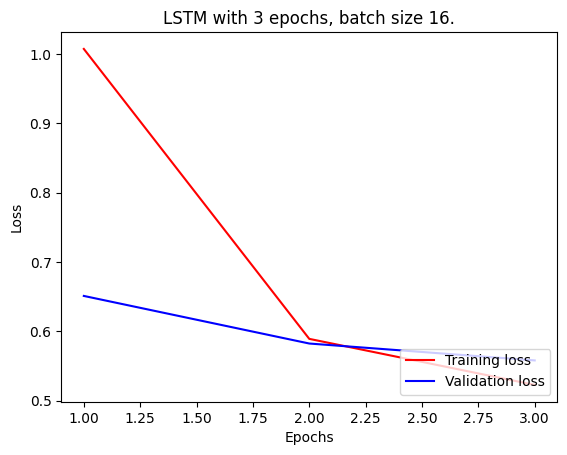

Epoch 1/5
2377/2377 ━━━━━━━━━━━━━━━━━━━━ 101s 41ms/step - loss: 1.6286 - val_loss: 0.6545
Epoch 2/5
2377/2377 ━━━━━━━━━━━━━━━━━━━━ 98s 41ms/step - loss: 0.6192 - val_loss: 0.5898
Epoch 3/5
2377/2377 ━━━━━━━━━━━━━━━━━━━━ 98s 41ms/step - loss: 0.5430 - val_loss: 0.5584
Epoch 4/5
2377/2377 ━━━━━━━━━━━━━━━━━━━━ 142s 41ms/step - loss: 0.4968 - val_loss: 0.5493
Epoch 5/5
2377/2377 ━━━━━━━━━━━━━━━━━━━━ 98s 41ms/step - loss: 0.4610 - val_loss: 0.5444


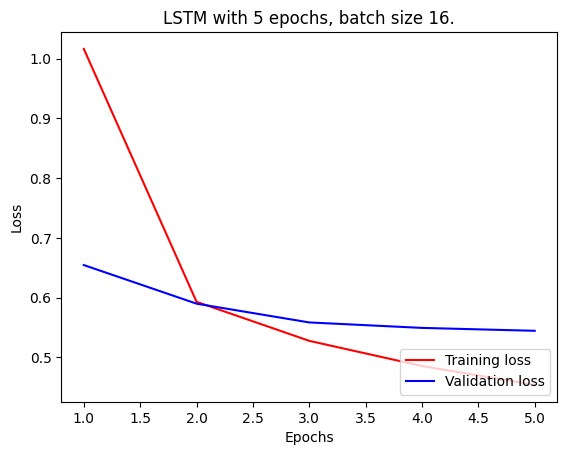

Epoch 1/3
595/595 ━━━━━━━━━━━━━━━━━━━━ 46s 74ms/step - loss: 2.4107 - val_loss: 0.8109
Epoch 2/3
595/595 ━━━━━━━━━━━━━━━━━━━━ 44s 74ms/step - loss: 0.7550 - val_loss: 0.6573
Epoch 3/3
595/595 ━━━━━━━━━━━━━━━━━━━━ 44s 74ms/step - loss: 0.6285 - val_loss: 0.6085


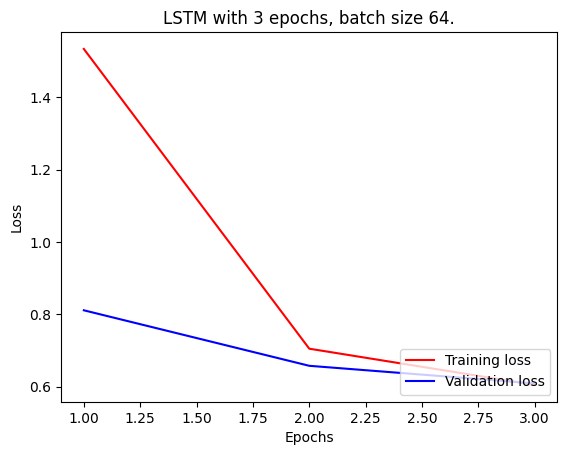

Epoch 1/5
595/595 ━━━━━━━━━━━━━━━━━━━━ 47s 74ms/step - loss: 2.4648 - val_loss: 0.8342
Epoch 2/5
595/595 ━━━━━━━━━━━━━━━━━━━━ 44s 74ms/step - loss: 0.7823 - val_loss: 0.6729
Epoch 3/5
595/595 ━━━━━━━━━━━━━━━━━━━━ 44s 74ms/step - loss: 0.6490 - val_loss: 0.6184
Epoch 4/5
595/595 ━━━━━━━━━━━━━━━━━━━━ 44s 73ms/step - loss: 0.5857 - val_loss: 0.5874
Epoch 5/5
595/595 ━━━━━━━━━━━━━━━━━━━━ 83s 75ms/step - loss: 0.5452 - val_loss: 0.5732


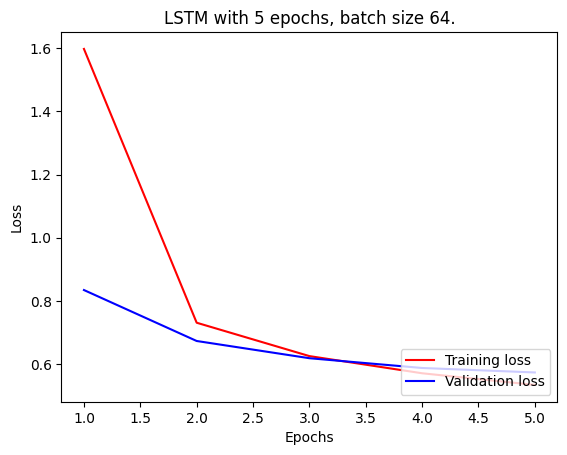

In [37]:
batch_sizes = [16, 64]
epochs = [3, 5]

# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'

param_grid = product(batch_sizes, epochs)
results = []

for batch_size, epochs in param_grid:
    model = MyModel(
      vocab_size=vocab_size,
      embedding_dim=embedding_dim,
      rnn_units=rnn_units
    )
    model.compile(optimizer='adam', loss=loss)

    checkpoint_prefix = os.path.join(checkpoint_dir, f"ckpt_{batch_size}_{epochs}" + "{epoch}.weights.h5")
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_prefix,
        save_weights_only=True)

    history = model.fit(train_dataset.batch(batch_size), validation_data=val_dataset.batch(batch_size), epochs=epochs, callbacks=[checkpoint_callback])
    results.append((batch_size, epochs, history, model, checkpoint_prefix))
    plot_history(epochs, batch_size, history)

As we can see, best results were derived using num epochs = 5 and batch size = 16. Other training setups got relatively similar results.

In [38]:
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Create a mask to prevent "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, strategy="temperature", states=None):
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, states = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]

    if strategy == "temperature":
      # Temperature-sampling strategy
      predicted_logits = predicted_logits/self.temperature
      # Apply the prediction mask: prevent "[UNK]" from being generated.
      predicted_logits = predicted_logits + self.prediction_mask
      # Sample the output logits to generate token IDs.
      predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
      predicted_ids = tf.squeeze(predicted_ids, axis=-1)
    elif strategy == "greedy":
      # Greedy sampling
      predicted_logits = predicted_logits/self.temperature
      predicted_logits = predicted_logits + self.prediction_mask
      # Sample the output logits to generate token IDs.
      predicted_ids = tf.math.argmax(predicted_logits, -1)
    elif strategy == "beam":
      # Beam search
      k = 3
      depth = 3

      predicted_logits = predicted_logits/self.temperature
      predicted_logits = predicted_logits + self.prediction_mask

      top_k_probs, top_k_ids = tf.math.top_k(predicted_logits, k=k)
      branches = (tf.transpose(top_k_ids), tf.transpose(top_k_probs), [states] * k, [states] * k)

      for i in range(depth):
        next_iter_branches = None

        for i in range(len(branches[2])):
          followups, total_prob, states, init_states = branches[0][i, :], branches[1][i], branches[2][i], branches[3][i]

          predicted_logits, states = self.model(inputs=followups[tf.newaxis, :], states=states, return_state=True)
          predicted_logits = predicted_logits[:, -1, :]

          predicted_logits = predicted_logits/self.temperature
          predicted_logits = predicted_logits + self.prediction_mask

          top_k_probs, top_k_ids = tf.math.top_k(predicted_logits, k=k)
          probs = top_k_probs

          top_k_ids = tf.transpose(top_k_ids)
          longer_followups = tf.stack([tf.concat([followups, top_k_ids[i, :]], 0) for i in range(k)])
          new_branch = (longer_followups, tf.transpose(probs * total_prob), [states] * k, [init_states] * k)
          next_iter_branches = new_branch if next_iter_branches is None else (
            tf.concat([next_iter_branches[0], new_branch[0]], 0),
            tf.concat([next_iter_branches[1], new_branch[1]], 0),
            next_iter_branches[2] + new_branch[2],
            next_iter_branches[3] + new_branch[3]
          )

        branches = next_iter_branches

      best_result = tf.math.argmax(branches[1])
      predicted_ids = tf.gather(branches[0], best_result)[:, 0]
      predicted_ids = tf.reshape(predicted_ids, [-1])
      states = tf.gather(tf.stack(branches[3]), best_result)
      states = [states[0, 0], states[0, 1]]

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, states

In [39]:
for batch_size, epochs, history, model, checkpoint_prefix in results:
  one_step_model = OneStep(model, chars_from_ids, ids_from_chars)

  for strategy in ["greedy", "temperature", "beam"]:
    start = time.time()
    states = None
    next_char = tf.constant(["Let's prove that you're wrong"])
    result = [next_char]

    for n in range(250):
      next_char, states = one_step_model.generate_one_step(next_char, strategy=strategy, states=states)
      result.append(next_char)

    result = tf.strings.join(result)
    end = time.time()
    print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
    print('\nRun time:', end - start)
    print("\n")

Let's prove that you're wronget $a\leq b\leq a\leq b\leq a\leq b\leq a\leq b\leq a\leq b\leq a\leq b\leq a\leq b\leq a\leq b\leq a\leq b\leq a\leq b\leq a\leq b\leq a\leq b\leq a\leq b\leq a\leq b\leq a\leq b\leq a\leq b\leq a\leq b\leq a\leq b\leq a\leq b\leq a\leq b\leq a\leq  

________________________________________________________________________________

Run time: 1.6544711589813232


Let's prove that you're wronged as:
  \[
  3(abc)^2 \geq 9abc(a+b+c) - 3(a+b+c)^3. -/
theorem lean_workbook_18290 (a b c : ℝ) (hx: a > 0 ∧ b > 0 ∧ c > 0) (hab : 1 ≤ a ∧ a + a + 1 / 2 ∧ b = 165) : (a + b) ^ 3 + (a + b) ^ 2 ≥ 0  := by
  /-
  Given \(abc = 1\), we can use the prope 

________________________________________________________________________________

Run time: 0.8797323703765869


Let's prove that you're wronget:
     \]
     Substituting this:
     \[
     \frac{1}{\frac{1}{x^2} + \frac{1}{y^2} + \frac{1}{z^2}}
  \]

import Mathlib

import Mathlib
import Aesop

set_option maxHeartbeats 

Greedy decoding produces highly repetitive output that gets stuck in a loop, such as "a ≤ b ≤ a ≤ b ≤ ...". This behavior is typical for greedy search because it always picks the most likely next character without considering future context. As a result, it tends to fall into short high-probability cycles. While it’s fast (1.65s in our case), it lacks creativity and diversity, making it a poor choice for generating complex, structured text (not to mention math) or proofs where coherence over longer spans is crucial.

Temperature sampling results are more diverse and realistic. It includes math-like expressions and even well-formed theorem statements , LaTeX-style formatting, and logical explanations like "Given abc=1...". This method introduces controlled randomness, which helps escape greedy loops and explore more meaningful sequences. It balances quality and creativity effectively, especially around a temperature of 1.0. Runtime is fast (~0.8–1.2s), making it efficient while yielding strong outputs that closely resemble real Lean math theorems or educational content.

Beam search, in theory, should outperform both greedy and temperature sampling by exploring multiple high-probability paths and selecting the best complete sequence. However, in our implementation, it underperforms. The generated content is erratic or redundant (import Mathlib repeated excessively), contains disjointed or corrupted math expressions, and fails to maintain logical coherence. The likely reasons include shallow search depth (depth = 3), too few beams (k = 3), and the fact that our beam search combines logits multiplicatively over steps, which can heavily penalize slightly less probable but semantically richer sequences. Additionally, since the decoder operates char-by-char, short token contexts may not be informative enough to guide beam search effectively. Beam decoding also took significantly longer (up to 25s), making it less computationally efficient.